# Example: grating coupler

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/GratingCoupler.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/GratingCoupler.ipynb), or just follow along with the output below.


In [1]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# tidy3d imports
! pip install -q --upgrade tidy3d
import tidy3d as td
import tidy3d.web as web

## Problem Setup

In this example, we model a 3D grating coupler in a Silicon on Insulator (SOI) platform.

A basic schematic of the design is shown below.  The simulation is about 19um x 4um x 5um with a wavelength of 1.55um and takes about 1 minute to simulate 10,000 time steps.

In the simulation, we inject a modal source into the waveguide and propagate it towards the grating structure.  The radiation from the grating coupler is then measured with a near field monitor and we use a far field projection to inspect the angular dependence of the radiation.

<img src="img/grating_coupler.png" width=600>

In [2]:
# basic parameters (note, all length units are microns)
nm = 1e-3
wavelength = 1550 * nm

# resolution
grids_per_wavelength = 50.0
dl = wavelength / grids_per_wavelength

# waveguide
wg_width = 400 * nm
wg_height = 220 * nm
wg_length = 2 * wavelength

# surrounding
sub_height = 2.0
air_height = 2.0
buffer = 0.5 * wavelength

# coupler
cp_width = 2 * wavelength
cp_length = 10 * wavelength
taper_length = 4 * wavelength

In [3]:
# sizes
Lx = buffer + wg_length + taper_length + cp_length
Ly = buffer + cp_width + buffer
Lz = sub_height + wg_height + air_height
sim_size = [Lx, Ly, Lz]

# convenience variables to store center of coupler and waveguide
wg_center_x = +Lx/2 - buffer - (wg_length + taper_length)/2
cp_center_x = -Lx/2 + buffer + cp_length/2
wg_center_z = -Lz/2 + sub_height + wg_height/2
cp_center_z = -Lz/2 + sub_height + wg_height/2

# materials
Air = td.Medium(epsilon=1.0)
Si = td.Medium(epsilon=3.47**2)
SiO2 = td.Medium(epsilon=1.44**2)

# source parameters
freq0 = td.constants.C_0 / wavelength
fwidth = freq0 / 10
run_time = 100 / fwidth

# PML layers
npml = 15

## Mode Solve
To determine the pitch of the waveguide for a given design angle, we need to compute the effective index of the waveguide mode being coupled into.  For this, we set up a simple simulation of the coupler region and use the mode solver to get the effective index. We will not run this simulation, we just add a ``ModeMonitor`` object in order to call the mode solver (implicitly called when using ``sim.viz_modes()`` below) and get the effective index of the wide-waveguide region.

Initializing simulation...
Mesh step (micron): [3.10e-02, 3.10e-02, 3.10e-02].
Simulation domain in number of grid points: [855, 180, 166].
Total number of grid points: 2.55e+07.
Total number of time steps: 96226.
Estimated data size (GB) of monitor monitor: 0.0010.


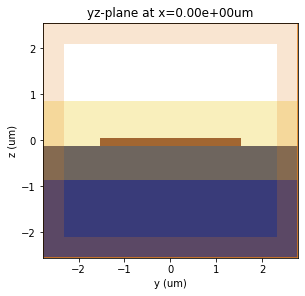

In [4]:
# grating parameters
design_theta_deg = 30
design_theta_rad = np.pi * design_theta_deg / 180
grating_height = 70 * nm

# do a mode solve to get neff of the coupler

sub = td.Box(
    center=[0, 0, -Lz/2],
    size=[td.inf, td.inf, 2 * sub_height],
    material=SiO2,
    name='substrate')

cp = td.Box(
    center=[0, 0, cp_center_z-grating_height/4],
    size=[td.inf, cp_width, wg_height-grating_height/2],
    material=Si,
    name='coupler')

mode_mnt = td.ModeMonitor(
    center=[0, 0, 0],
    size=[0, 8*cp_width, 8*wg_height],
    freqs=freq0)

sim = td.Simulation(
    size=sim_size,
    mesh_step=[dl, dl, dl],
    structures=[sub, cp],
    sources=[],
    monitors=[mode_mnt],
    run_time=run_time,
    pml_layers=[npml, npml, npml])

sim.viz_mat_2D(normal='x');



effective index of coupler region, mode 0 = 2.6910335965306373


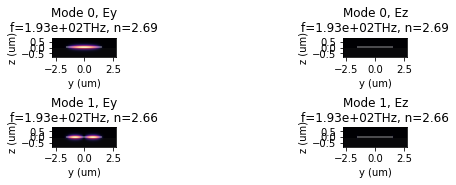

In [5]:
# This call will implicitly compute the first two modes of the monitor
sim.viz_modes(mode_mnt, mode_inds=[0, 1])

# Get the data for the mode corresponding to frequency index 0 and mode index 0
mode = sim.data(mode_mnt)["modes"][0][0]
neff = mode.neff
print(f'\n\neffective index of coupler region, mode 0 = {neff}')

## Create Simulation
Now we set up the grating coupler to simulate in Tidy3D.

In [6]:
# gratings
pitch = wavelength / (neff - np.sin(design_theta_rad))
grating_length = pitch / 2.0
num_gratings = int(cp_length / pitch)

sub = td.Box(
    center=[0, 0, -Lz/2],
    size=[td.inf, td.inf, 2 * sub_height],
    material=SiO2,
    name='substrate')

wg = td.Box(
    center=[wg_center_x, 0, wg_center_z],
    size=[buffer + wg_length + taper_length + cp_length/2, wg_width, wg_height],
    material=Si,
    name='waveguide')

cp = td.Box(
    center=[cp_center_x, 0, cp_center_z],
    size=[cp_length, cp_width, wg_height],
    material=Si,
    name='coupler')

tp = td.PolySlab(
    vertices=[
        [cp_center_x + cp_length/2 + taper_length, + wg_width/2],
        [cp_center_x + cp_length/2 + taper_length, - wg_width/2],
        [cp_center_x + cp_length/2, - cp_width/2],
        [cp_center_x + cp_length/2, + cp_width/2]],
    z_cent=wg_center_z,
    z_size=wg_height,
    material=Si,
    name='taper')

grating_left_x = cp_center_x - cp_length/2
gratings = [
    td.Box(
        center=[grating_left_x + (i + 0.5) * pitch, 0, cp_center_z + wg_height/2 - grating_height/2],
        size=[grating_length, cp_width, grating_height],
        material=Air,
        name=f'{i}th_grating')
    for i in range(num_gratings)]

In [7]:
mode_source = td.ModeSource(
    td.GaussianPulse(freq0, fwidth, phase=0),
    center=[Lx/2 - buffer, 0, cp_center_z],
    size=[0, 8*wg_width, 8*wg_height],
    direction='backward',
    amplitude=1.0,
    name='modal_source')

In [8]:
# distance to near field monitor
nf_offset = 50 * nm

plane_monitor = td.FreqMonitor(
    center=[0, 0, cp_center_z],
    size=[Lx, Ly, 0],
    freqs=freq0,
    name='full_domain_fields')

rad_monitor = td.FreqMonitor(
    center=[0, 0, 0],
    size=[Lx, 0, Lz],
    freqs=freq0,
    name='full_domain_fields')

near_field_monitor = td.FreqMonitor(
    center=[cp_center_x, 0, cp_center_z + wg_height/2 + nf_offset],
    size=[cp_length, cp_width, 0],
    freqs=freq0,
    name='radiated_near_fields')

In [9]:
sim = td.Simulation(
    size=sim_size,
    mesh_step=[dl, dl, dl],
    structures=[sub, wg, cp, tp] + gratings,
    sources=[mode_source],
    monitors=[plane_monitor, rad_monitor, near_field_monitor],
    run_time=run_time,
    pml_layers=[npml, npml, npml])

Initializing simulation...
Mesh step (micron): [3.10e-02, 3.10e-02, 3.10e-02].
Simulation domain in number of grid points: [855, 180, 166].
Total number of grid points: 2.55e+07.
Total number of time steps: 96226.
Estimated data size (GB) of monitor full_domain_fields: 0.0060.
Estimated data size (GB) of monitor full_domain_fields_1: 0.0054.
Estimated data size (GB) of monitor radiated_near_fields: 0.0024.


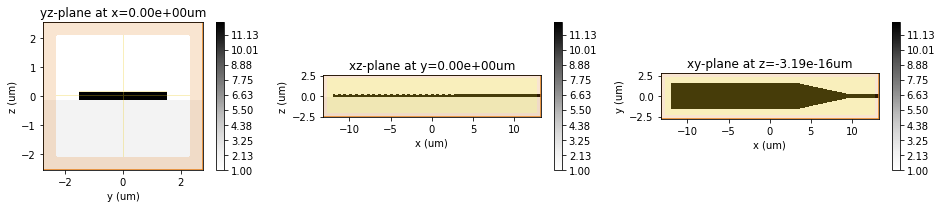

In [10]:
fig, axes = plt.subplots(1, 3, tight_layout=True, figsize=(14, 3))
for val, pos, ax in zip('xyz', (0, 0, -Lz/2 + sub_height + wg_height/2), axes):
    sim.viz_eps_2D(normal=val, position=pos, ax=ax, cbar=True)

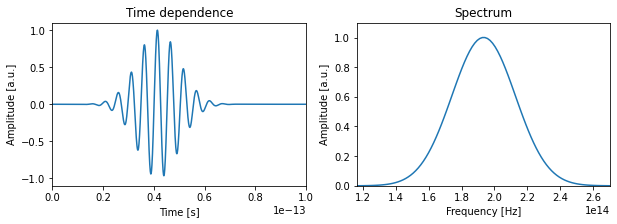

In [11]:
ax1, ax2 = sim.viz_source(mode_source)
ax1.set_xlim((0, 0.1e-12))  # note the pulse extends far beyond this time, adjust lims to inspect
plt.show()

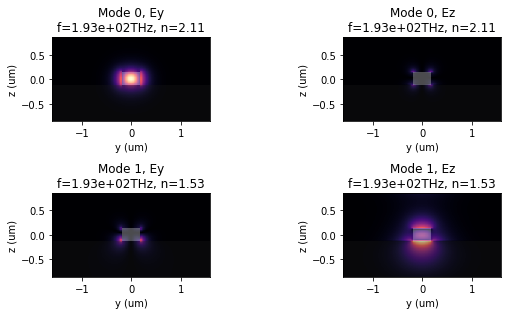

In [12]:
sim.viz_modes(mode_source, mode_inds=[0, 1])

# Mode 0 is the Ey dominant mode, so we choose that
mode_ind = 0
sim.set_mode(mode_source, mode_ind)

## Run Simulation

Run the simulation and plot the field patterns

In [13]:
# create a project, upload to our server to run
project = web.new_project(sim.export(), task_name='grating_coupler')
task_id = project['taskId']
web.monitor_project(task_id)

Uploading the json file...
Project "grating_coupler-19" status: success...    



In [14]:
# download the results and load into the original simulation
print('downloading results...')
web.download_results(task_id, target_folder='out')
print('done\n')
sim.load_results('out/monitor_data.hdf5')
with open("out/tidy3d.log") as f:
     print(f.read())

downloading results...
done

Applying source normalization to all frequency monitors using source index 0.
Simulation domain Nx, Ny, Nz: 855, 180, 166.
Total number of computational grid points: 2.55e+07.
Total number of time steps: 96226.
Time step: 5.373074e-17.
Starting Tidy3D... 

Setup time (s): 0.6112
- Time step   4811 / time 2.58e-13fs (  5 % done), field decay: 1.00e+00
- Time step   9622 / time 5.17e-13fs ( 10 % done), field decay: 9.55e-03
- Time step  14433 / time 7.75e-13fs ( 15 % done), field decay: 1.41e-04
- Time step  19245 / time 1.03e-12fs ( 20 % done), field decay: 6.71e-06
Field decay smaller than shutoff factor, exiting solver.
Solver time (s): 21.4092
Post-processing time (s): 0.1631



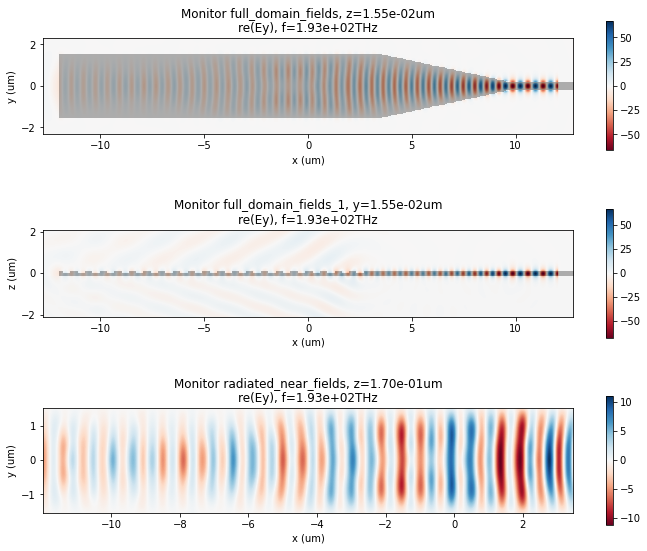

In [15]:
fig, axes = plt.subplots(3, 1, tight_layout=True, figsize=(10, 8))
for monitor, cpmp, ax in zip([plane_monitor, rad_monitor, near_field_monitor], 'yyy', axes):
    sim.viz_field_2D(monitor, comp=cpmp, ax=ax, cbar=True)

## Far Field Projection
Now we use the Near2Far feature of Tidy3D to compute the anglular dependence of the far field scattering based on the near field monitor.

In [16]:
# create range of angles to probe (note: polar coordinates, theta = 0 corresponds to vertical (z axis))
num_angles = 1101
thetas = np.linspace(-np.pi/2, np.pi/2, num_angles)

# make a near field to far field projector with the near field monitor data
n2f = td.Near2Far(sim.data(near_field_monitor))

# loop through angles and record the scattered cross section
Ps = np.zeros(num_angles)
for i in range(num_angles):
    Ps[i] = n2f.get_radar_cross_section(thetas[i], 0.0)

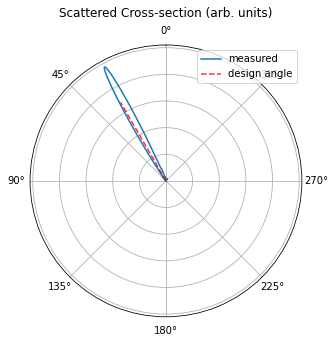

In [17]:
# plot the angle dependence
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5,5))
ax.plot(thetas, Ps, label='measured')
ax.plot([design_theta_rad, design_theta_rad], [0, np.max(Ps)*0.7], 'r--', alpha=0.8, label='design angle')
ax.set_theta_zero_location("N")
ax.set_yticklabels([])
ax.set_title("Scattered Cross-section (arb. units)", va='bottom')
plt.legend()
plt.show()

In [18]:
theta_expected = np.arcsin(np.abs(neff - wavelength / pitch))
print(f'expect angle of {(theta_expected * 180 / np.pi):.2f} degrees')
i_max = np.argmax(Ps)
print(f'got maximum angle of {(thetas[i_max] * 180 / np.pi):.2f} degrees')

expect angle of 30.00 degrees
got maximum angle of 28.31 degrees


The agreement between the target angle and the actual emission angle of the coupler is very good. The small difference comes from the fact that the design is very sensitive to the value of the effective index that we use in the coupler region, and that value depends on which waveguide height we pick in that region: the one with the grating comb, or without. In our setup, we used a thickness that is at the mid-point, but this is a heuristic choice which results in the small final mismatch in angles observed here.